In [1]:
"""
Vision-Language Finetuning for Language Models
"""
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
"""
Language Model Base
-------------------

We need a language model to serve as the initial point. This language model will be frozen during training and used to decode custom language-vision inputs
"""
import huggingface_hub
import transformers
from transformers import PhiForCausalLM, PhiForCausalLM
from transformers import AutoTokenizer, AutoModelForCausalLM


cache_dir = '/data/CVP/huggingface'


try:
    language_tokenizer = AutoTokenizer.from_pretrained(cache_dir)
    language_model = AutoModelForCausalLM.from_pretrained(cache_dir)
    
except:
    print('If we fail to load this model locally, do the code from huggingface thing')
    import os
    os.environ['CURL_CA_BUNDLE'] = ''

    language_tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", cache_dir = cache_dir)
    language_model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", cache_dir = cache_dir)

    language_tokenizer.save_pretrained(cache_dir)
    language_model.save_pretrained(cache_dir)


print(language_model)

inputs = language_tokenizer('''def print_prime(n):
   """
   Print all primes between 1 and n
   """''', return_tensors="pt", return_attention_mask=False)

outputs = language_model.generate(**inputs, max_length=40)
text = language_tokenizer.batch_decode(outputs)[0]
print(text)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (query_key_value): Linear(in_features=2560, out_features=7680, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=2560, o

In [3]:
"""
Vision Encoder
--------------

This vision model will encode images into representations which can be sequenced/patched into tokens under our custom tokenizer.
This will encode visual information for the language model to decode.
"""
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

import torch
import torch.nn as nn
from torchvision.transforms import Resize

vision_encoder = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")

# Freeze the pretrained loaded image encoder
for name, param in vision_encoder.named_parameters():
    param.requires_grad = False

#language_token_dimension = language_model.transformer.wte.weight.shape[1]
language_token_dimension = 2560
print(language_token_dimension)

#vision_encoder.fc = torch.nn.Linear(2048, language_token_dimension)
vision_encoder.fc = torch.nn.Identity()
vision_encoder.avgpool = torch.nn.Identity()

print(vision_encoder)

# Verify the newly-initialized tokenizer head requires a gradient
for name, param in vision_encoder.named_parameters():
    if param.requires_grad == True:
        print(name)
        
h, w = 512, 512
rand_input = torch.randn((1, 3, h, w))

resize = Resize(256)

rand_input = resize(rand_input)

# We use 2048 since it is the number of channels out of the vision
output = vision_encoder(rand_input)#.reshape(1, 2048, -1)
print(output.shape)
output = output.reshape(1,  2048, -1)
print('Vision encoder outputs a representation', output.shape)

class ImageTokenizer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(ImageTokenizer, self).__init__()
        self.projection = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        """
        Forward maps vision_encoder outputs
        
        (bs, in_size, seq_length)
        
        Broadcasting over the in_size dimension, leaving seq_length unaffected
        
        """
        return self.projection(x.permute(0,2,1))
    
    
print(vision_encoder.layer4[2].conv3.out_channels)
image_tokenizer = ImageTokenizer(in_dim = vision_encoder.layer4[2].conv3.out_channels, out_dim = language_token_dimension)

print('vision rep into tok', output.shape)
output = image_tokenizer(output)
print('out of tok', output.shape)

Using cache found in /home/moore278/.cache/torch/hub/pytorch_vision_main


2560
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

/home/moore278/miniconda3/envs/cvp/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Using the latest cached version of the dataset since lambdalabs/pokemon-blip-captions couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/moore278/.cache/huggingface/datasets/lambdalabs___pokemon-blip-captions/default/0.0.0/8b762e1dac1b31d60e01ee8f08a9d8a232b59e17 (last modified on Mon Feb 19 12:15:28 2024).


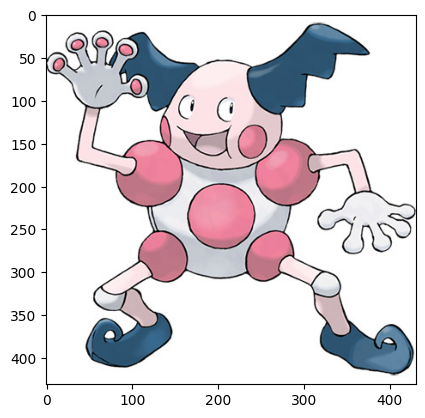

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=431x431>,
 'text': 'a cartoon character with a big smile on his face'}

In [4]:
"""
Sample Data
-----------

Sample data is borrowed from the `cppe-5` dataset. I use this data since it has images, string labels, and some interesting annotations such as bboxes we may enjoy using.
It is also a small, reasonable size for testing

Quote: https://huggingface.co/docs/datasets/en/object_detection
The dataset has the following fields:

image: PIL.Image.Image object containing the image.
image_id: The image ID.
height: The image height.
width: The image width.
objects: A dictionary containing bounding box metadata for the objects in the image:
id: The annotation id.
area: The area of the bounding box.
bbox: The object’s bounding box (in the coco format).
category: The object’s category, with possible values including Coverall (0), Face_Shield (1), Gloves (2), Goggles (3) and Mask (4).
"""

from datasets import load_dataset
import matplotlib.pyplot as plt
import warnings
import random

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    ds = load_dataset("lambdalabs/pokemon-blip-captions")
    ds

idx = random.randint(0, 40)

example = ds['train'][idx]

plt.imshow(example['image'])
plt.show()

example


In [28]:
"""
Seems like we want our own module so we can train multiple elements at once
"""
import torchvision

class VisionLanguageModel(nn.Module):
    """
    SAM for images
    """
    def __init__(self,
                 vision_encoder,
                 vision_tokenizer,
                 language_model,
                 language_tokenizer,
                 ):
        super(VisionLanguageModel, self).__init__() # initialize self._modules as OrderedDict - enables nested nn modules
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Model structural components
        self.vision_encoder = vision_encoder
        self.vision_tokenizer = vision_tokenizer
        
        self.language_model = language_model
        self.language_tokenizer = language_tokenizer
        
        # Image utilities
        self.toTensor = torchvision.transforms.ToTensor()
        self.resize = Resize((256, 256), antialias = True)
        
        # Language components - custom tokens we use to format the prompt
        imstart_str = '<|imstart|>'
        imend_str = '<|imend|>'
        #textend_str = '<|endoftext|>'
        language_prompt = "This image contains"
        

        language_tokenizer.add_tokens(imstart_str, special_tokens = True)
        language_tokenizer.add_tokens(imend_str, special_tokens = True)
        
        # Update langauge model's token embedding matrix
        self.language_model.resize_token_embeddings(len(self.language_tokenizer))
        
        # Hold vector representing elements of our custom prompt
        self.start_vec = self.embed_ints(torch.tensor(self.language_tokenizer(imstart_str)['input_ids'], device = self.device)).unsqueeze(0)
        self.end_vec = self.embed_ints(torch.tensor(self.language_tokenizer(imend_str)['input_ids'], device = self.device)).unsqueeze(0)
        self.query_vec = self.embed_ints(torch.tensor(self.language_tokenizer(language_prompt)['input_ids'], device = self.device)).unsqueeze(0)
        #self.textend_vec = self.embed_ints(torch.tensor(self.language_tokenizer(textend_str)['input_ids'], device = self.device)).unsqueeze(0)
        
        # Loss
        self.bceloss = nn.BCEWithLogitsLoss()
        
    def forward(self, inputs_embeds):
        """
        Given aggregated dataloader batch containing:
        batch['image']: PIL Image (bs, 3, H, W)
        batch['label]: str sentence image caption
        """
        # batch image to image tokens using vision encoder and image tokenizer
        #tokenized_image = self.image_forward(batch['image'])
        
        # get prompt for llm
        #llm_vector_prompt = self.format_forward(tokenized_image)
        
        output = language_model.forward(inputs_embeds = inputs_embeds)
        
        return output['logits'][:, -1] # Last logit
    
    def pred_next(self, batch):
        tokenized_image = self.image_forward(batch['image'])
        
        llm_vector_prompt = self.format_forward(tokenized_image).to(self.device)
        
        logit_output = self.forward(inputs_embeds = llm_vector_prompt)
        
        return logit_output
        
    
    # def forward(self, idx, targets=None):
    #     B, T = idx.shape

    #     # idx and targets are both (B,T) tensor of integers
    #     tok_emb = self.token_embedding_table(idx) # (B,T,C)
    #     pos_emb = self.position_embedding_table(torch.arange(T, device=self.device)) # (T,C)
    #     x = tok_emb + pos_emb # (B,T,C)
    #     x = self.blocks(x) # (B,T,C)
    #     x = self.ln_f(x) # (B,T,C)
    #     logits = self.lm_head(x) # (B,T,vocab_size)

    #     if targets is None:
    #         loss = None
    #     else:
    #         B, T, C = logits.shape
    #         logits = logits.view(B*T, C)
    #         targets = targets.view(B*T)
    #         loss = F.cross_entropy(logits, targets)

    #     return logits, loss

    def generate(self, batch, max_new_tokens = 10):
        # idx is (B, T) array of indices in the current context
        tokenized_image = self.image_forward(batch['image'])
        
        # get initial prompt for llm
        llm_vector_prompt = self.format_forward(tokenized_image).to(self.device)
        
        logit_outputs = []
        for _ in range(max_new_tokens):
            # Forward on prompt
            logit_output = self.forward(inputs_embeds = llm_vector_prompt)
            logit_outputs.append(logit_output)
            
            #print(llm_vector_prompt.shape, logit_output.shape)
            # Add EMBEDDED output to current sequence
            int_output = logit_output.argmax(dim = 1)
            #print('int output', int_output)
            new_vec = self.embed_ints(int_output).unsqueeze(0)
            llm_vector_prompt = torch.cat((llm_vector_prompt, new_vec), dim = 1)
        
        logit_outputs = torch.stack(logit_outputs, dim = 1)
        print('generate constructed outputs', logit_outputs.shape)
        return logit_outputs
    
    def image_forward(self, image):
        """
        Handles the image component of the prompting and returns the token sequence of the image
        """
        # Input image, text caption
        image = self.toTensor(image).unsqueeze(0)
        image = self.resize(image).to(self.device)
        
        # Encode from image pixels to representation and reshape to (bs, vision_dim, tokens)
        encoded_image = self.vision_encoder(image).reshape(1, 2048, -1)
        
        # Project representation to language tokens with trainable 'image tokenizer'
        tokenized_image = self.vision_tokenizer(encoded_image)
        
        return tokenized_image
    
    def format_forward(self, tokenized_image):
        """
        To account for our unique vision-language component, we need to format the input vectors as:
        [\start_image, image_tokens, \end_image, prompt]
        
        In order for the language model to understand what is going on with our od prompting scheme
        """
        llm_input = torch.cat((self.start_vec, tokenized_image, self.end_vec, self.query_vec), dim = 1)#.permute(0,2,1)

        return llm_input
        
    def embed_ints(self, tokens):
        """
        Use the model's existing integer tokens to return vector embeddings:
        """
        return self.language_model.get_input_embeddings().to(self.device)(tokens)
    
    def loss_function(self, logits, int_labels):
        """
        logits FloatTensor shape: [B*T, vocab_size] (sequence of probabilities over vocab)
        labels intTensor shape: [B*T] (sequence of int vocab positions)
        """
        
        return torch.nn.functional.cross_entropy(logits, int_labels)
        

In [ ]:



device = 'cuda'

# # Load model directly
# from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

# processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
# vision_encoder = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-large-patch14")

vision_tokenizer = ImageTokenizer(in_dim = vision_encoder.layer4[2].conv3.out_channels, out_dim = language_token_dimension)

vlm = VisionLanguageModel(vision_encoder = vision_encoder,
                          #vision_processor = processor,
                          vision_tokenizer = vision_tokenizer,
                          language_model = language_model,
                          language_tokenizer = language_tokenizer).to(device)

for param in vlm.parameters():
    param.requires_grad = True
    
# Parameters: Freeze vision encoder and language model
for param in vlm.language_model.parameters():
    param.requires_grad = False
    
# for param in vlm.vision_encoder.parameters():
#     param.requires_grad = False
    
# Add LoRA to vlm.language_model
from peft import get_peft_model, LoraConfig

peft_config = LoraConfig(
task_type=None, inference_mode=False, r=32, lora_alpha=16, lora_dropout=0.1, target_modules=['fc1', 'fc2']
)

vlm.language_model = get_peft_model(vlm.language_model, peft_config)
vlm.language_model.print_trainable_parameters()

optimizer = torch.optim.Adam(vlm.parameters(), lr = 3e-3)

#train_dataloader = torch.utils.data.DataLoader(ds['train'], batch_size = 1)

from torch.nn.functional import one_hot
torch.set_grad_enabled(True)  # Context-manager 

avg_losses = []
losses = []

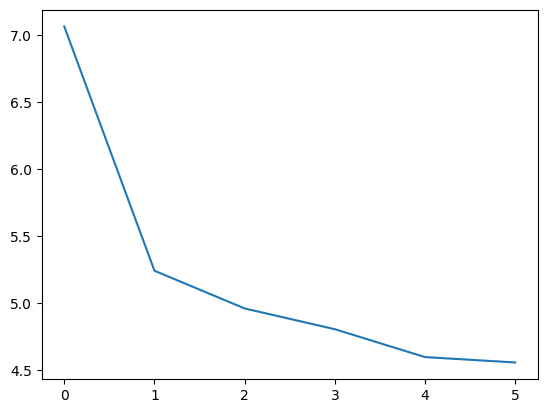

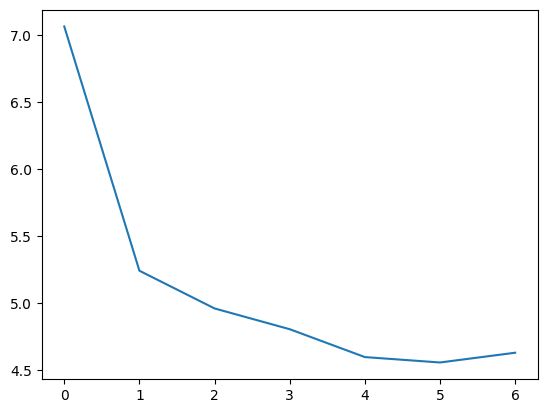

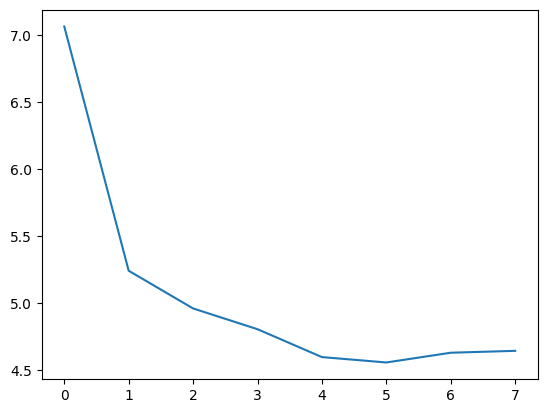

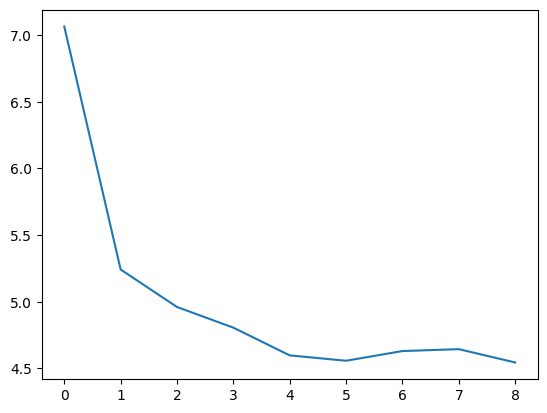

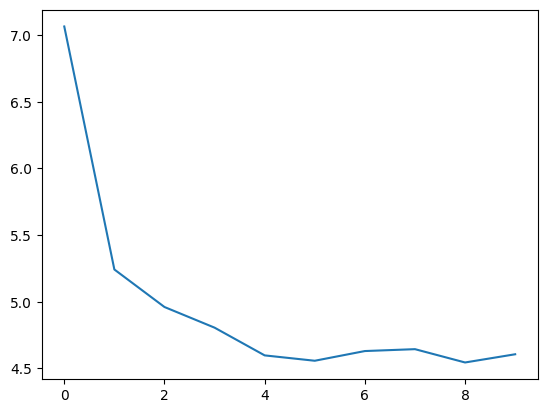

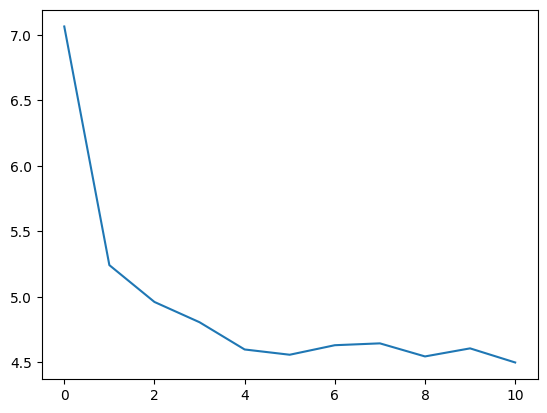

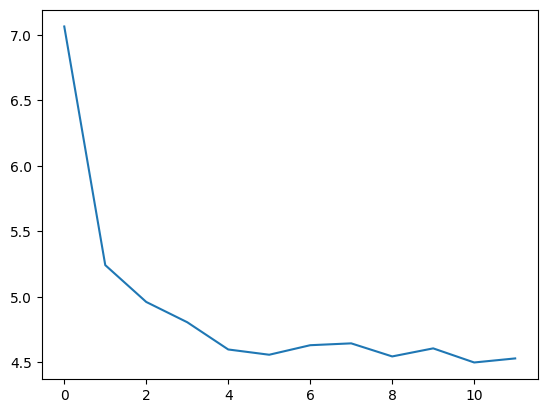

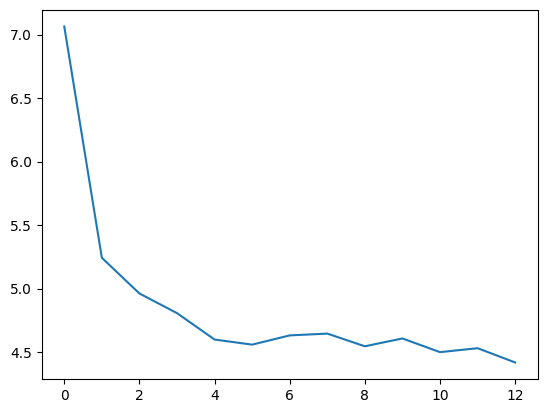

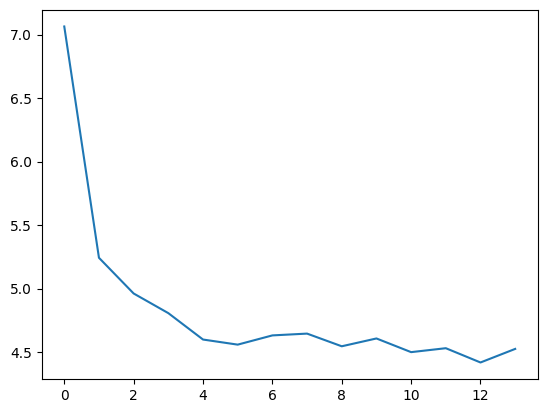

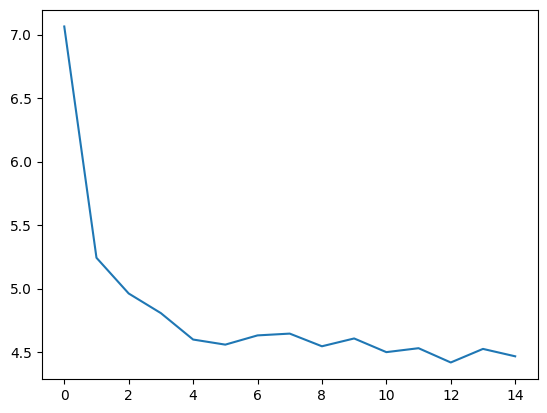

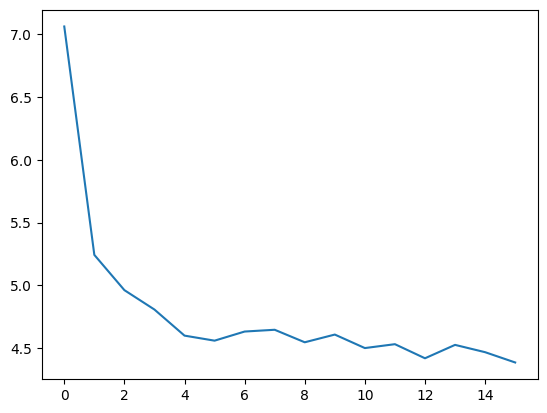

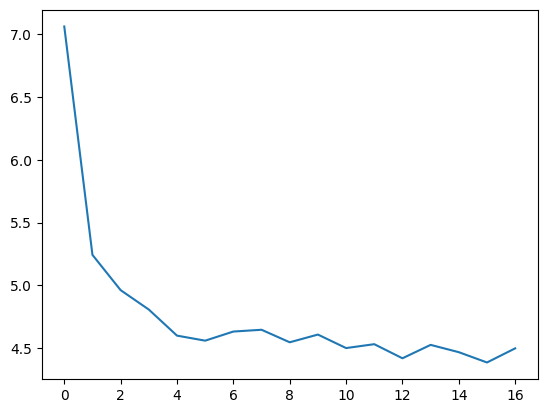

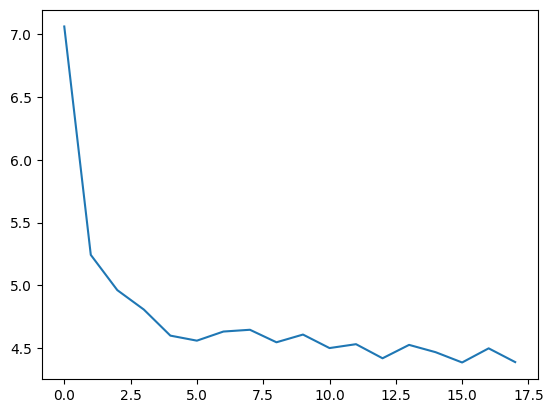

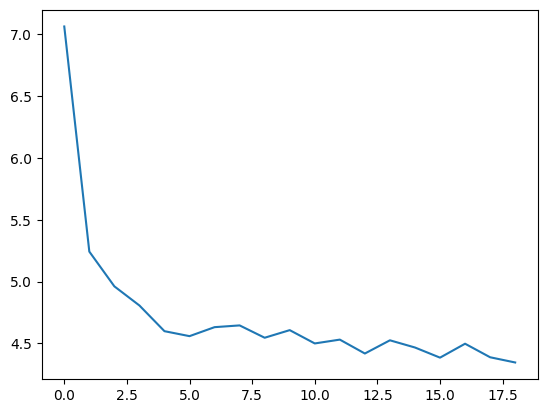

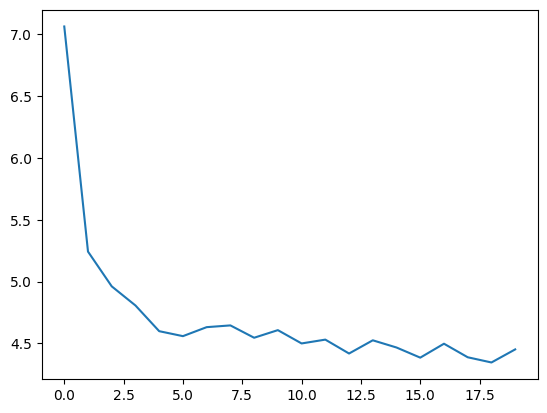

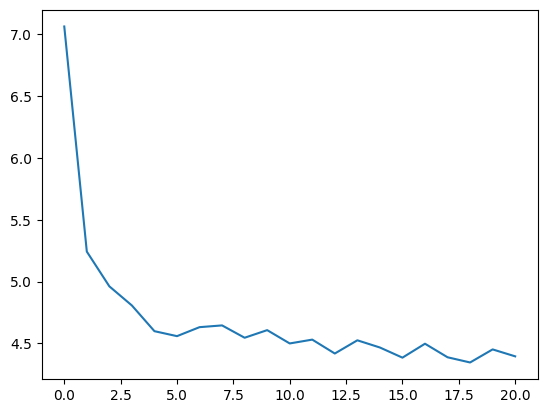

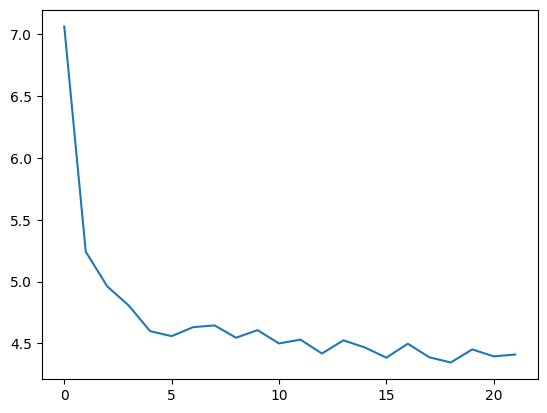

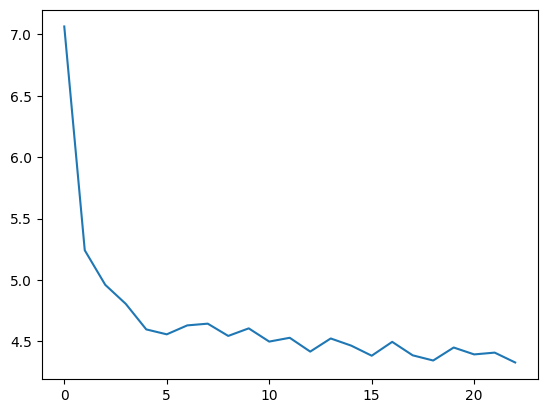

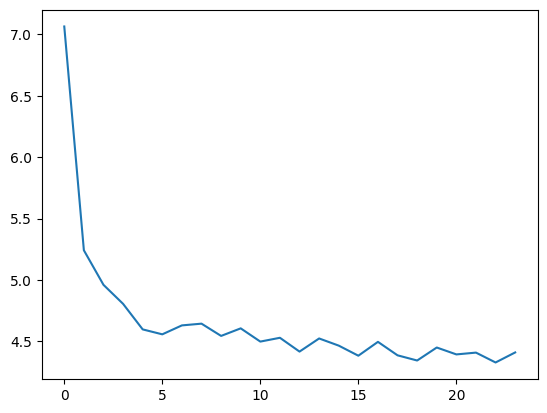

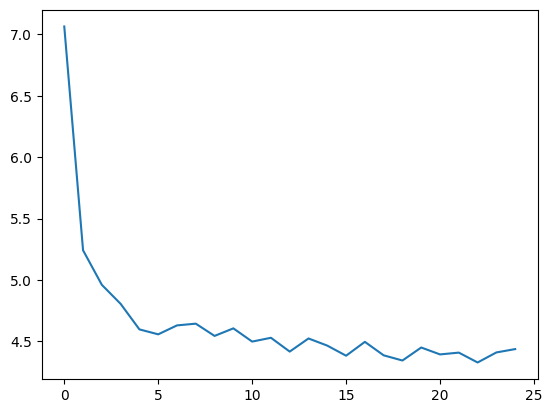

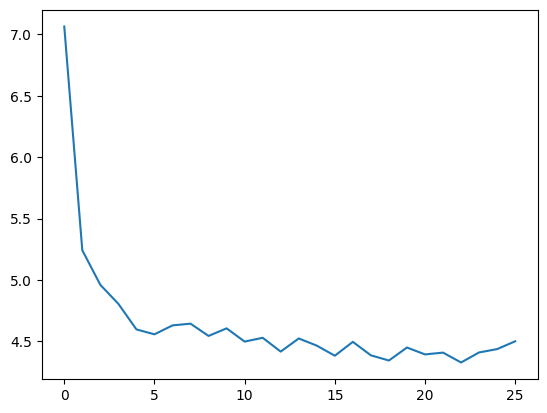

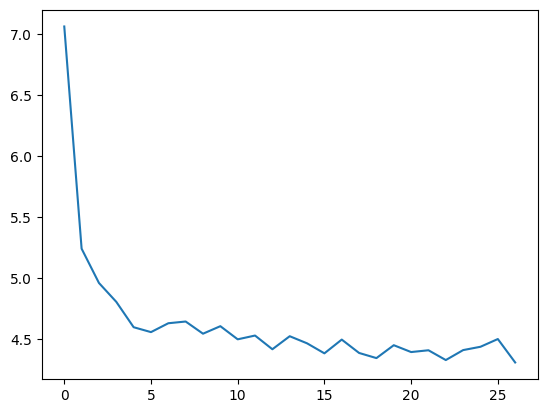

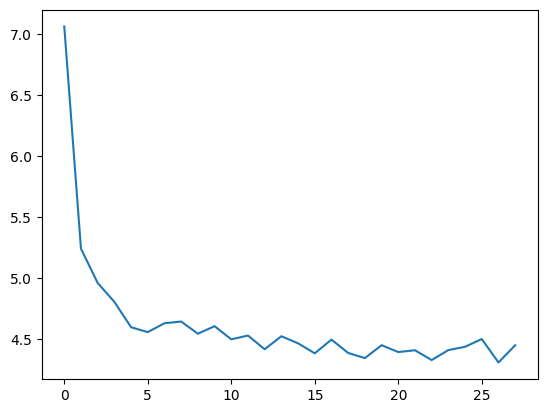

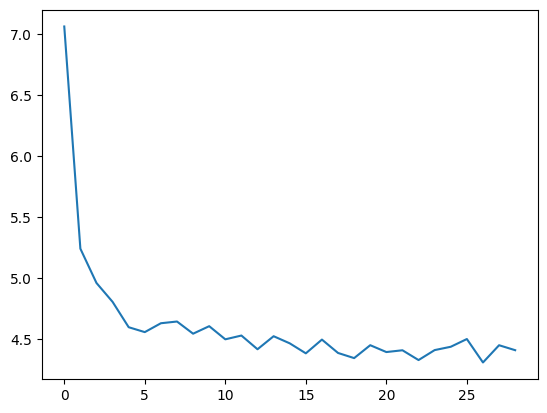

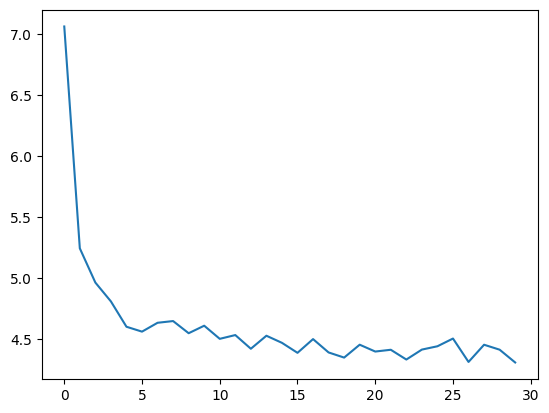

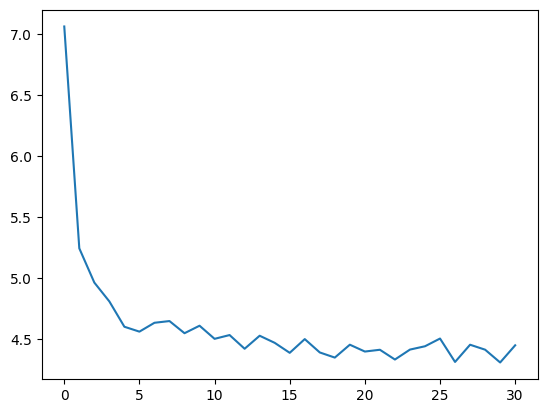

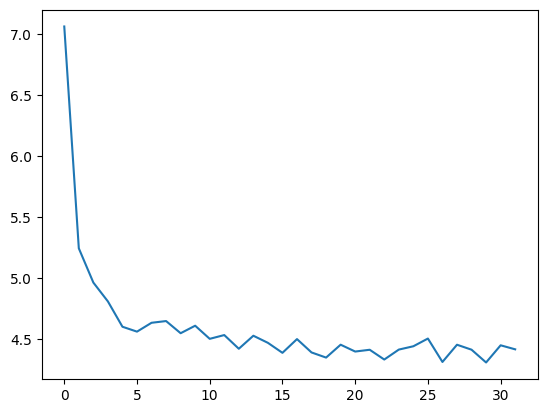

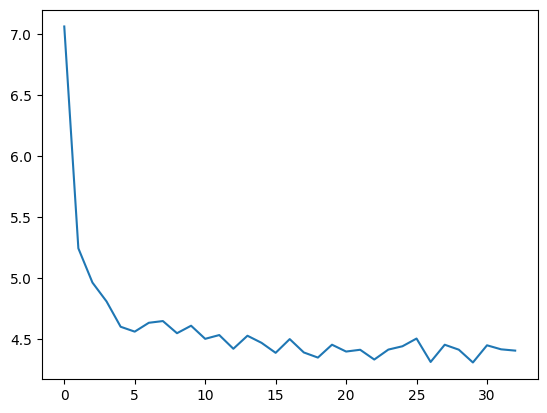

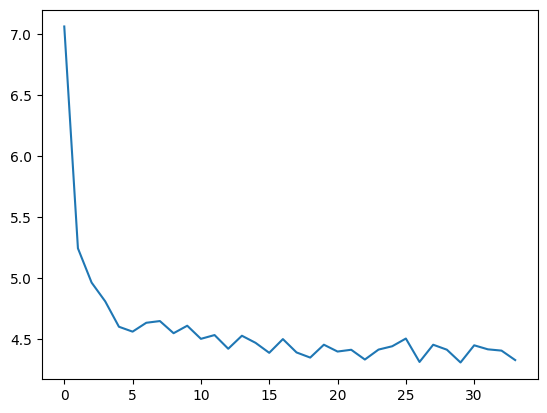

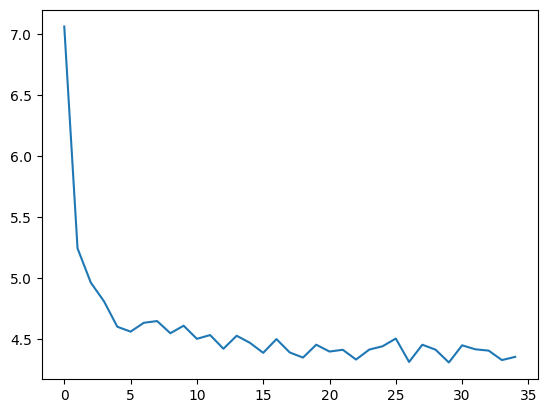

In [42]:
"""
Encode Image data to representation, and patchify representation into token sequences.

Currently, this code is mis-understanding that tokenizers DISCRETIZE inputs.
This means that we do not input representations of size 768 into the model - but rather INTEGERS representating a vector on a lookup table.


This raises the question of how we can input image: we need to represent them as integers?
OR we need to make our own torch llm, where we can skip the lookup-table part and get right into the 


It looks like we could get around this by providing inputs in the form of embeddings rather than integers! input_embeds = tensor
This means we just need to do the emebddings for the strings manually, then provide the image embeddings ourselves:
"""


for _ in range(30): # epochs
    for bi, sample in enumerate(ds['train']):
        #print(sample['label'])
        #print(breaker)
        vlm.zero_grad()
        
        # At training time, rather than calling generate, I think we want to be calling 
        
        #logits = vlm.generate(sample).squeeze()
        logits = vlm.pred_next(sample).squeeze()
        #print('logits', logits.shape)
        #print(sample['text'])
        
        str_label = sample['text']
        #print(str_label)
        
        tok_label = vlm.language_tokenizer(str_label)['input_ids']
        #print(tok_label)
        
        #print('randomly reduce tok label length, and save last token of it out:')
        last_ind = random.randint(1, len(tok_label)-1)
        last_tok = tok_label[last_ind]
        subset_tok_label = tok_label[:last_ind]
        
        #print(tok_label, last_ind)
        #print(subset_tok_label, last_tok)
        
        #one_hot_vec = one_hot(torch.tensor(tok_label, dtype = int), num_classes = len(vlm.language_tokenizer))#.unsqueeze(0)
        #print(one_hot_vec.shape)
        
        #print('attempting loss between output, onhotvec', logits.shape, one_hot_vec.shape)
        
        from torch.nn.utils.rnn import pad_sequence
        #seqs = pad_sequence([logits, one_hot_vec])
        
        #y_hat = seqs[:, 0]
        #y = seqs[:, 1]
        
        #print('padded', y_hat.shape, y.shape)
        
        #print(logits.shape, last_tok)
        target = torch.zeros((50297), device = vlm.device)
        target[last_tok] = 1
        loss = vlm.loss_function(logits, target)
        
        loss.backward()
        optimizer.step()
        
        # Inference
        
        #print('y_hat, y', logits.argmax(dim=0), last_tok)
        #out_str = vlm.language_tokenizer.decode(pred_ints)
        #print('vlm says:', out_str)
        
        # for name, param in vlm.named_parameters():
        #     if param.requires_grad and param.grad is None:
        #         print('wanted grad got none:', name, param.requires_grad, param.grad is None)
            
        #print(loss.data.item())
        losses.append(loss.data.item())
        
        if bi > 0 and bi % 500 == 0:
            avg_losses.append(sum(losses) / len(losses))
            losses = []
            import matplotlib.pyplot as plt
            plt.plot(avg_losses)
            plt.show()

In [ ]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Wed Feb 21 15:18:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:1B:00.0 Off |                    0 |
| N/A   50C    P0             215W / 300W |  81049MiB / 81920MiB |     99%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--